Math 485 Spring 2019 Prof Lega
Supermodel Group

Created by: Alex Stoken 18 Feb 2019

Last updated: 26 Feb 2019

This file takes input data and returns the minimum connection coefficient vector C

# TODO
* [DONE] make (F,C) output a csv so that it's ready to be read in again
* add docstrings
* [DONE] increase efficiency
* [DONE] wrap the animation routine in a function
* [DONE] use a random C vector to start to find other local minima
* write a routine to increase K over time
* [DONE] Make (SM - Truth) plot for each direction 
* Check how t is calculated with the gamma element
* Make run over random K

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize #has the conjugate gradient method
import scipy.integrate as integrate #ODE solver
from IPython.display import clear_output

#plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import datetime #for reference
%matplotlib inline

In [2]:
def load_lorentz_data(fname):
    """
    loads data from xlsx file, returns np.array()
    """
    data = pd.read_excel(fname, names=['x','y','z'], header = None)
    return np.array(data)
x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')


def get_lastest_C(fname):
    """
    returns last C vect from input file
    """
    C_headers = ['F','cx12', 'cx13', 'cx23', 'cx21', 'cx31', 'cx32','cy12', 'cy13', 'cy23', 'cy21', 'cy31', 'cy32', 'cz12', 'cz13', 'cz23', 'cz21', 'cz31', 'cz32'] 
    F_C_df = pd.read_csv(fname, header = None,index_col = False, names = C_headers)
    return np.array(F_C_df.iloc[-1])[1:]



In [21]:
def cost_fn(C, K =200, gamma= 0.4, delta =1, fname= None, data = None, verbose = True):
    """
    calculate value of cost fn from paper for given model
    
    parameters:
    C - vector of conn coefficients, this is the indep var
    K - number of points to train on/calculate cost fn over
    gamma - disocunt factor to reduce importance of future error
    delta - length of time to integrate over, in seconds 
    fname - file to write each (F,C) pair to 
    data - true values of the lorenz63 model
    verbose - if true, prints output 
    """
    step = 0.01
    d = 0.2 * delta 
    
    clear_output(wait = True)
    #time from 0 to 20 seconds, with a point taken every 0.01 s
    t = np.arange(0,d*K,d)
    #t = np.linspace(0,step* K ,K)
    
    #take the integral of the lorentz system with the given Cs
    sum_k = 0
    
    #set x_o,y_o, x_o
    
    
    #do the summation in the cost function over all K
    for i in range(K): 
        #sum_k = integrate.quad(integrand,t[i], t[i]+delta,args = (data, C, t,i,0.4))[0]
        
        t_initial = t[i]
        
        t_integrate = np.arange(t_initial, t_initial+1, step )
        
        x_init = [x_o[i,a] for a in range(3) for a in range(3)]

        #each K we want to integrate the ODE w/ connection coefficiants
        sol = integrate.odeint(conn_lorentz, x_init, t_integrate, args=(C,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
        
        s_model = supermodel(sol)
 
        #set this value to 0, so we can start the addition ourselves
        integrand = 0
        
        for j in range(int(delta/step)):
            #range is from t_i to t_i + delta, but delta is 1 full second, so 100 of our timesteps
            truth = data[i+j,0:3]
            diff = s_model[j] - truth 
       
            #paper suggestion
            integrand += np.linalg.norm(diff)**2 * (gamma**t_integrate[j]) 
            
            #if we want t - t_i (Lega suggestion)
            #integrand += np.linalg.norm(diff)**2 * (gamma**(t_integrate[j]- t_integrate[0])) 
            
        sum_k += integrand
    
    #compute normalization constant 
    
    norm = 1/ (K * delta)
    
    #set F to be returned 
    F = sum_k * norm
    
    #write C vector to file for later access
    if fname != None:
        with open(fname,'a') as f:    
            C_str = str(C.tolist())
            C_to_file = C_str.strip('[]')
            f.write(str(F) + ',' + C_to_file +',' + '\n')
    
    #print out current F and C vec
    if verbose == True: print('\r', F,C , end='')
        
    #return cost F
    return F

def integrand(t, data, C, t_large,i,gamma= 0.4):
    """
    Not used at this time
    """
    sol = integrate.odeint(conn_lorentz, x_init, t_large, args=(C,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
    s_model = supermodel(sol)
    model = s_model[i]
    truth = data[i,0:3]
    diff = model - truth 
    
    return np.linalg.norm(diff)**2 * (gamma**t) 

def conn_lorentz(x_vect, t0,C, sig = [10,10,10], rho = [28,28,28], beta = [8 /3,8/3,8/3]):
    """
    Parameters:
    sigma, rho, beta - model parameters from climate data, defaults to all true values

    
    Returns: 
    derivs vector for next timestep 
    """
    
    #unpack x vector
    x1,y1,z1, x2, y2, z2, x3, y3, z3 = x_vect
    
    
    #unpack C vector
    cx12, cx13, cx23, cx21, cx31, cx32, \
    cy12, cy13, cy23, cy21, cy31, cy32, \
    cz12, cz13, cz23, cz21, cz31, cz32 = C
    
    #calculate sum of C vals
    C_x1 = cx12 * (x2 - x1) + cx13 * (x3-x1)
    C_x2 = cx21 * (x1 - x2) + cx23 * (x3-x2)
    C_x3 = cx31 * (x1 - x3) + cx32 * (x2-x3)

    C_y1 = cy12 * (y2 - y1) + cy13 * (y3-y1)
    C_y2 = cy21 * (y1 - y2) + cy23 * (y3-y2)
    C_y3 = cy31 * (y1 - y3) + cy32 * (y2-y3)
    
    C_z1 = cz12 * (z2 - z1) + cz13 * (z3-z1)
    C_z2 = cz21 * (z1 - z2) + cz23 * (z3-z2)
    C_z3 = cz31 * (z1 - z3) + cz32 * (z2-z3)
    
    #unpack parameters
    sig1,sig2,sig3 = sig
    rho1,rho2,rho3 = rho
    beta1,beta2,beta3 = beta
    
    #write diff equations
    dx1 = sig1 * (y1-x1) + C_x1
    dy1 = x1 * (rho1 - z1) -y1 + C_y1
    dz1 = x1 * y1 - beta1 *z1 +C_z1

    dx2 = sig2 * (y2-x2) + C_x2
    dy2 = x2 * (rho2  -z2) - y2 + C_y2
    dz2 = x2 * y2 - beta2 *z2 +C_z2

    dx3 = sig3 * (y3-x3) + C_x3
    dy3 = x3 * (rho3 - z3) - y3 + C_y3
    dz3 = x3 * y3 - beta3 *z3 +C_z3
    
    #return list of derivatives
    return [dx1,dy1,dz1,dx2,dy2,dz2,dx3,dy3,dz3]

def supermodel(sol):
    """
    input is three 3-vectors of model solns
    
    returns 3 vector of supermodel solns
    """
    x_s = 1/3 * (sol[:,0:3] + sol[:,3:6] + sol[:,6:9])
    return x_s

In [22]:
def run_sm_optimization(last_fname = None, verbose = True, k = 10):
    """
    parameters:
    last_fname - name of the file from the last run of the algorithm 
    
    return:
    optimal C vec
    """
    #set parameter values
    #taken from paper
    gamma = 0.4
    delta = 1
    K = k


    #load data and set initial conditions
    x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')
    x_init = [x_o[0,i] for i in range(3) for i in range(3)]
    C_init = np.zeros(18)
    d = 0.2
    t = np.arange(0,d*K + delta,0.01)
    
    
    C_headers = ['F','cx12', 'cx13', 'cx23', 'cx21', 'cx31', 'cx32','cy12', 'cy13', 'cy23', 'cy21', 'cy31', 'cy32', 'cz12', 'cz13', 'cz23', 'cz21', 'cz31', 'cz32'] 

    #if given a last file to restart from, tell gradient method that this is our guess
    #else make random guess between in [10,10] for each C component
    if last_fname != None:
        C_opt_guess = get_lastest_C(last_fname)
    else:
        C_opt_guess = 10*np.random.random(18)

        
        
    #find true values for comparison
    truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
    data = truth[:, 0:3]
    

    #make file to print (F,C) pairs to
    fname = 'F_list_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + '.csv'
    f = open(fname, 'w+')
    f.close()
    
    #begin optimizatio
    print(f'SM optimization beginning with C = {C_opt_guess}')
    
    #
    C = optimize.fmin_cg(cost_fn, C_opt_guess, args=(K,gamma,delta, fname, data, verbose), full_output=True)

    print(C)
    print('SM has been optimized')
    
    return C


# --------------------- RUN OPTIMIZATION ------------------------

# List of which files are which:
    
* K:10 time: t0 paper File: 'F_list_2019-03-24_10:58:12.csv' SM1 routine finished
* K:10 time: t0 File: 'F_list_2019-03-16_22:02:39.csv' SM2 routine finished
* K:10 time: t - ti File: 'F_list_2019-03-26_09:32:42.csv' SM3 routine finished
* K:10 time: t - ti File: 'F_list_2019-04-07_23:50:53.csv' SM4 routine finished - fixed alg
* K: 10 time: t0 File: 'F_list_2019-04-08_00:11:37.csv' SM5 Routine finished - fixed alg
* K: 200 time: t0 File: F_list_2019-03-28_15:50:08.csv Routine finished
* K: 200 time: t0 File: F_list_2019-04-08_03:11:55.csv SM6 Routine finished - fixed alg


In [31]:
#to run from random start
#run_sm_optimization()

#to run from last place left off
last_fname = 'F_list_2019-04-08_02:50:06.csv'
C_opt = run_sm_optimization(last_fname, verbose = True, k = 200)

#to run a new version
#C_opt = run_sm_optimization()

 0.010971802025512841 [ 1.84332593e+01 -1.12513291e+01  1.32748009e+01  1.09863041e+01
  5.09629588e+01  2.69311861e+01 -4.69474830e+01  6.27827644e+01
  2.47695532e+01  3.35456166e+01 -1.03952356e+01  5.10869337e+01
  1.14668619e+01  3.34830101e+00  1.75361008e+01  1.74482513e+01
 -7.44599446e-03  1.17448127e+01]Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.010972
         Iterations: 10
         Function evaluations: 1772
         Gradient evaluations: 88
(array([ 1.84332593e+01, -1.12513291e+01,  1.32748009e+01,  1.09863041e+01,
        5.09629588e+01,  2.69311861e+01, -4.69474830e+01,  6.27827644e+01,
        2.47695532e+01,  3.35456166e+01, -1.03952356e+01,  5.10869337e+01,
        1.14668619e+01,  3.34830102e+00,  1.75361008e+01,  1.74482513e+01,
       -7.44599300e-03,  1.17448127e+01]), 0.010971802018643837, 1772, 88, 2)
SM has been optimized


# ------------------------VISUALIZATIONS --------------------------------
## SUPERMODEL VS DATA (ANIMATION)

In [16]:

import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.gridspec as gridspec
%matplotlib inline

def animate_l63(sm1_file, sm2_file, output_fname, k, plt_labels = ['SM1', 'SM2'], t_max = 1000, frame_num = 5000):
    """
    This cell creates and saves the animated time progression of the supermodel
    """
    
    C_opt = get_lastest_C(sm1_file)
    C_opt2 = get_lastest_C(sm2_file)

    C_init = np.zeros(18)
    t = np.arange(0,t_max,0.01)
    x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')
    x_init = [x_o[0,i] for i in range(3) for i in range(3)]
    
    model_C_opt = integrate.odeint(conn_lorentz, x_init, t, args=(C_opt,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
    model_C_opt2 = integrate.odeint(conn_lorentz, x_init, t, args=(C_opt2,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
    
    x_s = supermodel(model_C_opt)
    x_s2 = supermodel(model_C_opt2)
    
    truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
    data = truth[:, 0:3]
    


    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(12, 1)
    ax = plt.subplot(gs[:-3,0], projection = '3d')
    ax2 = plt.subplot(gs[-3,0])
    ax3 = plt.subplot(gs[-2,0])
    ax4 = plt.subplot(gs[-1,0])
    ax.axis('tight')
   
    """ax = fig.add_axes([0.1, 3/6+.1, .9, .9], projection='3d')
    ax2 = fig.add_axes([0.1, 1/6, .9, 1/6-.05])
    ax3 = fig.add_axes([0.1, 2/6, .9, 1/6-.05])
    ax4 = fig.add_axes([0.1, 3/6, .9, 1/6-.05])
    ax.axis('tight')
    """

    """
    colors = ['xkcd:azure','xkcd:wheat']
    c_pts = ['navy', 'orange']
    """

    #order: SM1, SM2, data
    colors = [(238/255, 251/255, 3/255, 0.85),(117/255, 160/255, 255/255, 0.54), (224/255, 91/255, 91/255, 0.45)]
    c_pts =['xkcd:orange',(6/255, 49/255, 166/255,1), 'xkcd:crimson']

    labels = plt_labels + ['Truth']

    lines = sum([ax.plot([], [], [], '-', c=c, label = l)
             for c,l in zip(colors, labels)], [])
    pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in c_pts], [])

    diff_x, = ax2.plot([],'-', c= colors[0], label = labels[0])
    diff_y, = ax3.plot([],'-',c= colors[0],label = labels[0])
    diff_z, = ax4.plot([],'-',c= colors[0],label = labels[0])


    diff_x2, = ax2.plot([],'-', c= colors[1],label = labels[1])
    diff_y2, = ax3.plot([],'-',c= colors[1],label = labels[1])
    diff_z2, = ax4.plot([],'-',c= colors[1],label = labels[1])

    diff_lines = [diff_x, diff_y, diff_z, diff_x2, diff_y2, diff_z2]


    x_t = np.asarray([x_s, x_s2, data])


    x_diff1 = x_s[:,0]- data[:,0]
    y_diff1 = x_s[:,1]- data[:,1]
    z_diff1 = x_s[:,2]- data[:,2]

    x_diff2 = x_s2[:,0]- data[:,0]
    y_diff2 = x_s2[:,1]- data[:,1]
    z_diff2 = x_s2[:,2]- data[:,2]


    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend(fontsize = 20)
    ax.set_title("""Lorenz 63 Supermodels
    (K=%s training pts) versus Truth""" %str(k), fontsize= 25)
    n=200

    y_lim_diff = 30
    for a in [ax2,ax3,ax4]:
        a.set_xlim(0,10)
        a.set_ylim(-y_lim_diff,y_lim_diff)

        a.legend(fontsize = 'small')

    ax4.set_xlabel('time [s]')
    ax2.set_title('Model - Truth')
    ax2.set_ylabel('x')
    ax3.set_ylabel('y')
    ax4.set_ylabel('z')
    ax2.set_xticks([])
    ax3.set_xticks([])


    def init():
        for line, pt in zip(lines, pts):
            line.set_data([], [])
            line.set_3d_properties([])

            pt.set_data([], [])
            pt.set_3d_properties([])

        for line in diff_lines:
            line. set_data([],[])

        return lines + pts + diff_lines

    def animate(i):
        i = (2 * i) % x_t.shape[1]

        for line, pt, xi in zip(lines, pts, x_t):
            x, y, z = xi[:i].T
            line.set_data(x, y)
            line.set_3d_properties(z)

            pt.set_data(x[-1:], y[-1:])
            pt.set_3d_properties(z[-1:])


        diff_x.set_data(t[:i],x_diff1[:i])
        diff_y.set_data(t[:i],y_diff1[:i])
        diff_z.set_data(t[:i],z_diff1[:i])

        diff_x2.set_data(t[:i],x_diff2[:i])
        diff_y2.set_data(t[:i],y_diff2[:i])
        diff_z2.set_data(t[:i],z_diff2[:i])
        for a in [ax2,ax3,ax4]:
            if a.get_xlim()[1]== t[i]:
                a.set_xlim(0,t[i]+50)


        ax.view_init(30, 0.3 * i)
        fig.canvas.draw()
        return lines + pts + diff_lines

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_num, interval=10, blit=True)

    ani.save(output_fname + '.mp4', writer = 'ffmpeg' )

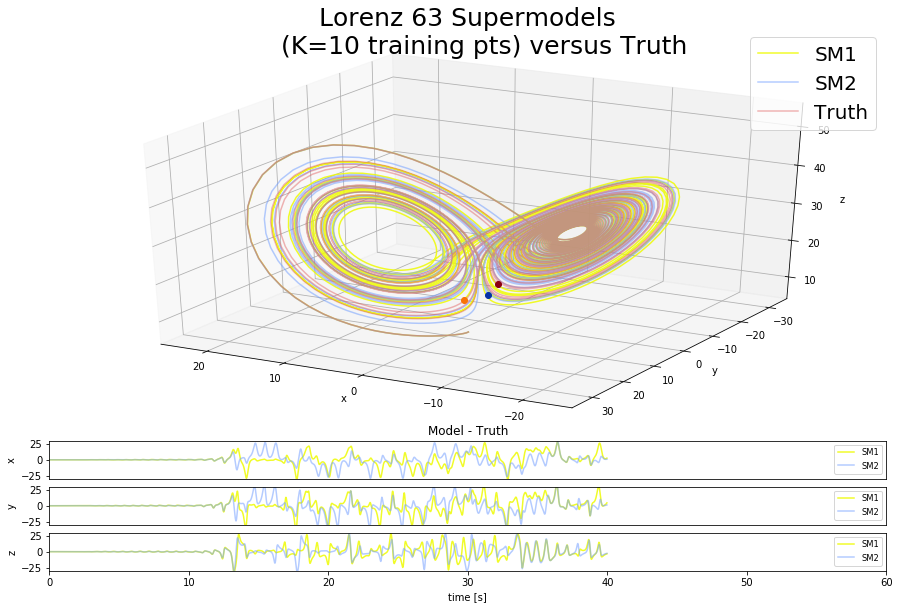

In [35]:
animate_l63('F_list_2019-04-08_03:11:55.csv', 'F_list_2019-04-08_00:11:37.csv', 'fast_test2',10, t_max= 1000, frame_num=2000)

## F vs C Plots 

In [64]:
def make_F_C_plots(C, data, C_names , interval = (-3,3.5), step = .5, k = 10, save_name = None):
    """
    Parameters:
    C - connection coefficients to build supermodel
    data - true values for cost function analysis
    C_names - titles of conn coeffs for plots
    interval - interval to adjust each conn coeff by and recalculate cost fn
    step - frequency of stepping through this interval
    k - number of points to calculate cost fn on
    save_name - file name for completed pdf
    
    Returns:
    figure (type matplotlib fig) with all of the 18 plots on it
    """
    k = k
    fig, axs = plt.subplots(nrows=6, ncols=3, constrained_layout=True, figsize = (17,15))

    for i, ax in enumerate(axs.flatten()):
        new_C = C.copy()
        F_vals = []
        F_vals.append(cost_fn(new_C, K=k, data = data, verbose = False))
        C_vals = []
        C_vals.append(C[i])
        for j in np.arange(interval[0],interval[1],step):
 
            new_C[i] = C[i] + j   

            C_vals.append(new_C[i])
            F_vals.append(cost_fn(new_C, K = k, data = data, verbose = False))

        ax.scatter(C_vals[1:], F_vals[1:])
        ax.scatter(C_vals[0], F_vals[0], c='red')
        ax.set_xlabel(C_names[i], fontsize=11)
        ax.set_ylabel('F', fontsize=11)
        ax.set_title(C_names[i], fontsize=22)
        
        ax.text(.05,.8, r'$C_{opt}$ =' + str(C_vals[0]), transform = ax.transAxes)
    
    if save_name:
        plt.savefig(save_name)
    return fig

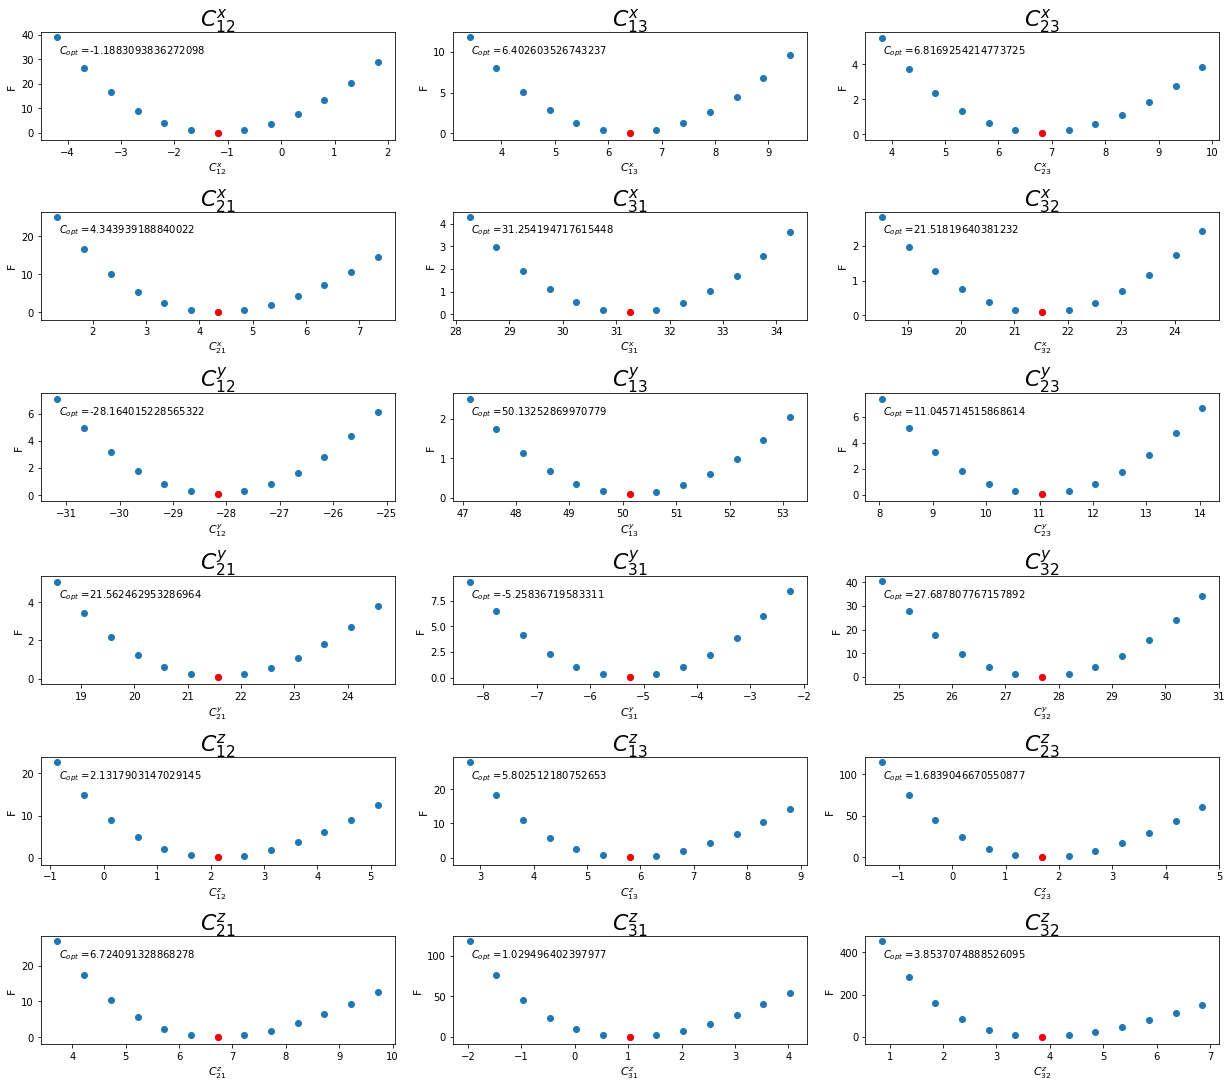

In [74]:
x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')
x_init = [x_o[0,i] for i in range(3) for i in range(3)]
C_init = np.zeros(18)
C_zeros = np.zeros(18)
t = np.arange(0,20,0.01)
C_headers = [r'$C^x_{12}$', r'$C^x_{13}$', r'$C^x_{23}$', r'$C^x_{21}$', r'$C^x_{31}$', r'$C^x_{32}$',r'$C^y_{12}$', r'$C^y_{13}$', r'$C^y_{23}$', r'$C^y_{21}$', r'$C^y_{31}$', r'$C^y_{32}$', r'$C^z_{12}$', r'$C^z_{13}$', r'$C^z_{23}$', r'$C^z_{21}$', r'$C^z_{31}$', r'$C^z_{32}$'] 
truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_zeros,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
data = truth[:,0:3]
#C_latest = np.array([-1.542089124,6.555705489,6.911540307,3.992398058,30.9881037,21.40875076,-28.31332381,49.82258357,10.89791526,21.09793666,-5.222914054,27.25178126,2.079585368,5.697524811,1.586266223,6.426121113,1.193244465,3.611735179])
C_latest = get_lastest_C('F_list_2019-03-24_10:58:12.csv')
f_c_plots = make_F_C_plots(C_latest,data, C_headers, save_name = 'f_c_plots_sm1_k10.pdf')

# IGNORE BELOW THIS (PLAY AREA)

In [32]:
C_opt = get_lastest_C('F_list_2019-04-07_23:50:53.csv')
C_opt2 = get_lastest_C('F_list_2019-04-08_00:11:37.csv')
C_opt3 = get_lastest_C('F_list_2019-04-08_03:11:55.csv')

C_init = np.zeros(18)
t = np.arange(0,20,0.01)
x_init = [x_o[0,i] for i in range(3) for i in range(3)]

model_C_opt = integrate.odeint(conn_lorentz, x_init, t, args=(C_opt,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
model_C_opt2 = integrate.odeint(conn_lorentz, x_init, t, args=(C_opt2,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
model_C_opt3 = integrate.odeint(conn_lorentz, x_init, t, args=(C_opt3,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))

truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
data = truth[:, 0:3]

x_s = supermodel(model_C_opt)
x_s2 = supermodel(model_C_opt2)
x_s3 = supermodel(model_C_opt3)

In [33]:
for i in [0,1,2]:
    if i == 0:
        print('x')
    elif i ==1:
        print('y')
    elif i ==2:
        print('z')
    diff_t_ti = abs(x_s2[:,i] - data[:,i])
    diff_t = abs(x_s[:,i]- data[:,i])
    diff_t_2 = abs(x_s3[:,i]- data[:,i])

    print('w/ time from t0:\t' + str(diff_t.sum()) +'\nWith time from t0:\t'+ str(diff_t_2.sum())+ '\nWith time from ti:\t'+ str(diff_t_ti.sum())+'\n')

x
w/ time from t0:	8345.570621323817
With time from t0:	5253.117439224674
With time from ti:	6760.124486047197

y
w/ time from t0:	9723.790147820144
With time from t0:	6250.556397888859
With time from ti:	7868.6629393162

z
w/ time from t0:	11837.5872894595
With time from t0:	5627.907181716025
With time from ti:	5303.358983174153



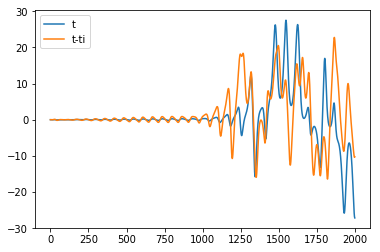

In [34]:
plt.plot(x_s2[:,0]- data[:,0], label = 't')
plt.plot(x_s[:,0]- data[:,0], label ='t-ti')
plt.legend()